Input the data

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box
import osmnx as ox

foodatlas=pd.read_csv("data\Food Access Research Atlas.csv")
snap = pd.read_csv("data\Historical SNAP Retailer Locator Data 2004-2024.csv", 
                   encoding='utf-8', 
                   encoding_errors='replace')
place=gpd.read_file("data\PLACES__Census_Tract_Data_(GIS_Friendly_Format),_2024_release_20251126.geojson")
philly=gpd.read_file("data\City_Limits.geojson")


<>:6: SyntaxWarning: invalid escape sequence '\F'
<>:7: SyntaxWarning: invalid escape sequence '\H'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\C'
<>:6: SyntaxWarning: invalid escape sequence '\F'
<>:7: SyntaxWarning: invalid escape sequence '\H'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\C'
C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\966121630.py:6: SyntaxWarning: invalid escape sequence '\F'
  foodatlas=pd.read_csv("data\Food Access Research Atlas.csv")
C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\966121630.py:7: SyntaxWarning: invalid escape sequence '\H'
  snap = pd.read_csv("data\Historical SNAP Retailer Locator Data 2004-2024.csv",
C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\966121630.py:10: SyntaxWarning: invalid escape sequence '\P'
  place=gpd.read_file("data\PLACES__Census_Tract_Data_(GIS_Friendly_Format),_2024_release_20251126.geojson")
C:\Users\wen

Filter and reproject the data 

In [2]:
#filter to snap retailers in Philly
phillysnap=snap.loc[snap['County'] == 'PHILADELPHIA']
#select retailers that are still operating
phillysnapfiltered=phillysnap.loc[phillysnap['End Date'].isna()]
#convert to geodataframe
phillygeo = [Point(xy) for xy in zip(phillysnapfiltered['Longitude'], phillysnapfiltered['Latitude'])]
snapgdf=gpd.GeoDataFrame(phillysnapfiltered,geometry=phillygeo)
snapgdf.set_crs(epsg=4326, inplace=True)
snapgdf.to_crs(epsg=2272)

,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,geometry
544588,1254758,1 Stop Deli & Grocery 1,Convenience Store,3701,Germantown Ave,NaN,Philadelphia,PA,19140,3619,PHILADELPHIA,40.009357,-75.150856,08/23/2016,NaN,POINT (2696471.018 256979.057)
544590,1487550,10 Brothers Food Market Corp,Small Grocery Store,1801,W Venango St,NaN,Philadelphia,PA,19140,4019,PHILADELPHIA,40.008730,-75.158010,04/05/2022,NaN,POINT (2694474.591 256691.85)
544603,1344176,11th & Tioga Mini Market Inc,Small Grocery Store,1047,W Tioga St,NaN,Philadelphia,PA,19140,4348,PHILADELPHIA,40.005505,-75.146450,02/19/2019,NaN,POINT (2697746.062 255612.802)
544607,1044500,1312 DJ Inc. T/A VIP Market,Medium Grocery Store,1312,Walnut St,NaN,Philadelphia,PA,19107,NaN,PHILADELPHIA,39.949135,-75.162680,02/24/2012,NaN,POINT (2693802.947 234953.345)
544610,1351007,16th And York Mini Market Inc,Small Grocery Store,2401,N 16th St,NaN,Philadelphia,PA,19132,4439,PHILADELPHIA,39.989864,-75.158730,05/14/2019,NaN,POINT (2694474.619 249816.317)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553380,1607336,Zamzam Halal Market LLC,Medium Grocery Store,7923,Bustleton Ave,NaN,Philadelphia,PA,19152,3302,PHILADELPHIA,40.057404,-75.052610,08/19/2024,NaN,POINT (2723445.028 275298.927)
553383,1416224,Zapata Mini Market Inc,Small Grocery Store,910,W Duncannon Ave,NaN,Philadelphia,PA,19141,4012,PHILADELPHIA,40.030987,-75.138400,01/11/2021,NaN,POINT (2699725.733 264958.008)
553386,1518283,Zemzem Halal Poultry Inc,Meat/Poultry Specialty,6202,Oxford Ave,NaN,Philadelphia,PA,19111,5810,PHILADELPHIA,40.042240,-75.088760,10/03/2022,NaN,POINT (2713496.868 269470.423)
553392,1228403,Zheng Mini Market,Small Grocery Store,1701,S Bancroft St,NaN,Philadelphia,PA,19145,2204,PHILADELPHIA,39.929653,-75.172410,03/18/2016,NaN,POINT (2691283.232 227779.639)


In [3]:
#filter foodatlas data
foodatlasphilly=foodatlas.loc[foodatlas['County']=='Philadelphia County']
foodatlasphillyfiltered = foodatlasphilly[['CensusTract', 'HUNVFlag', 'TractHUNV', 'TractSNAP']]
#filter the place data to obesity rate only
placefiltered=place[['tractfips','obesity_crudeprev']]
foodatlasphillyfiltered

,CensusTract,HUNVFlag,TractHUNV,TractSNAP
57339,42101000100,0,606.0,12.0
57340,42101000200,0,510.0,95.0
57341,42101000300,0,789.0,32.0
57342,42101000401,0,921.0,202.0
57343,42101000402,0,1150.0,78.0
...,...,...,...,...
57715,42101980300,0,0.0,0.0
57716,42101980700,0,0.0,0.0
57717,42101980800,0,0.0,0.0
57718,42101980900,0,0.0,0.0


Merge atlas data with shapefile

In [4]:
import pygris 
tracts_gdf = pygris.tracts(
    state='42',
    county='101',
    year=2019,
    cache=True
)
tracts_gdf['CensusTract'] = (tracts_gdf['GEOID']).astype(int)
foodatlas_sf = tracts_gdf.merge(
    foodatlasphillyfiltered,
    on='CensusTract',
    how='left'
)

Download census data using API

In [5]:
import pandas as pd
import cenpy
from cenpy import products

acs = cenpy.remote.APIConnection('ACSDT5Y2023')
demographic_vars = [
    "B01003_001E",
    "B02001_003E",
    "B03003_003E",
]

economic_vars = [
    "B19013_001E",
    "B17001_002E",
    "B17001_001E",
    "B23025_005E",
    "B23025_003E",
    "B22003_002E",
    "B22003_001E",
]

all_vars = demographic_vars + economic_vars

var_names = {
    "B01003_001E": "total_population",
    "B02001_003E": "black_alone",
    "B03003_003E": "hispanic_latino",
    "B19013_001E": "median_household_income",
    "B17001_002E": "poverty_total",
    "B17001_001E": "poverty_universe",
    "B23025_005E": "unemployed",
    "B23025_003E": "labor_force",
    "B22003_002E": "snap_recipients",
    "B22003_001E": "snap_universe",
}

census_data = acs.query(
    cols=all_vars,
    geo_unit='tract',
    geo_filter={
        'state': '42',
        'county': '101'
    }
)

print(f"Downloaded {len(census_data)} census tracts")


census_data.rename(columns=var_names, inplace=True)


for col in var_names.values():
    census_data[col] = pd.to_numeric(census_data[col], errors='coerce')

print("Calculating derived metrics...")

census_data["poverty_rate"] = census_data["poverty_total"] / census_data["poverty_universe"] * 100
census_data["unemployment_rate"] = census_data["unemployed"] / census_data["labor_force"] * 100
census_data["snap_rate"] = census_data["snap_recipients"] / census_data["snap_universe"] * 100
census_data["pct_black"] = census_data["black_alone"] / census_data["total_population"] * 100
census_data["pct_hispanic"] = census_data["hispanic_latino"] / census_data["total_population"] * 100

print("Done.")


c:\Users\wensh\miniconda3\envs\geospatial\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Downloaded 408 census tracts
Calculating derived metrics...
Done.


Merge Census data with shapefile

In [6]:
import pygris 
tracts_gdf = pygris.tracts(
    state='42',
    county='101',
    year=2023,
    cache=True
)
tracts_gdf['tract'] = tracts_gdf['TRACTCE']
merged_gdf = tracts_gdf.merge(
    census_data[["median_household_income",'poverty_rate',"unemployment_rate","snap_rate","pct_black","pct_hispanic",'state', 'county','tract']],
    on='tract',
    how='left'
)

Download POI from OSM

In [7]:
foodstore = ox.features_from_place(
    "Philadelphia, PA", tags={"shop": ["food", "supermarket", "grocery"]}
)

foodstore_proj=foodstore.to_crs(epsg=2272)

Create a grid containing potential index

In [8]:
import numpy as np
grid_size = 50  # meters
minx, miny, maxx, maxy = philly.total_bounds
x_coords = np.arange(minx, maxx + grid_size, grid_size)
y_coords = np.arange(miny, maxy + grid_size, grid_size)

In [9]:
# START FROM SCRATCH with correct bounds
philly_proj = philly.to_crs(epsg=2272)
minx, miny, maxx, maxy = philly_proj.total_bounds  # Get PROJECTED bounds

grid_size = 50  # meters (makes sense in EPSG:2272)
x_coords = np.arange(minx, maxx + grid_size, grid_size)
y_coords = np.arange(miny, maxy + grid_size, grid_size)

print(f"Creating {len(x_coords)-1} x {len(y_coords)-1} grid = {(len(x_coords)-1)*(len(y_coords)-1)} cells")

# Create grid
from shapely.geometry import box
polygons = []
for x in x_coords[:-1]:
    for y in y_coords[:-1]:
        polygons.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:2272')
print(f"Grid created: {len(grid)} cells")

# Clip to Philadelphia boundary
grid = gpd.overlay(grid, philly_proj, how='intersection')
print(f"After clipping to Philly: {len(grid)} cells")

# Continue with your network analysis...
grid['centroid'] = grid.centroid
centroids = grid.set_geometry('centroid')

Creating 1791 x 2003 grid = 3587373 cells
Grid created: 3587373 cells
After clipping to Philly: 1593451 cells


Calculate the nearest distance to snap retailer and foodstore using networking analysis

In [10]:
G = ox.graph_from_place("Philadelphia, Pennsylvania, USA", network_type='drive')
G = ox.project_graph(G, to_crs="EPSG:2272")
foodstore_proj['geometry'] = foodstore_proj.geometry.centroid
foodstore_proj_x = foodstore_proj.geometry.x.values
foodstore_proj_y = foodstore_proj.geometry.y.values

centroid_nodes = ox.distance.nearest_nodes(G,
                                           X=centroids.geometry.x.values,
                                           Y=centroids.geometry.y.values)
food_nodes = ox.distance.nearest_nodes(G,
                                       X=foodstore_proj_x,
                                       Y=foodstore_proj_y)
snap_nodes = ox.distance.nearest_nodes(G,
                                       X=snapgdf.geometry.x.values,
                                       Y=snapgdf.geometry.y.values)


In [11]:
import networkx as nx
# Convert nearest nodes to Python lists
food_nodes = food_nodes.tolist()
snap_nodes = snap_nodes.tolist()
centroid_nodes = centroid_nodes.tolist()

print("Calculating distances to food stores...")
food_dist_dict = nx.multi_source_dijkstra_path_length(G, food_nodes, weight='length')

print("Calculating distances to SNAP retailers...")
snap_dist_dict = nx.multi_source_dijkstra_path_length(G, snap_nodes, weight='length')

# Map distances back to centroids
centroids['dist_food_ft'] = [food_dist_dict.get(n, np.nan) for n in centroid_nodes]
centroids['dist_snap_ft'] = [snap_dist_dict.get(n, np.nan) for n in centroid_nodes]

# Convert to meters if desired
centroids['dist_food_m'] = centroids['dist_food_ft'] * 0.3048
centroids['dist_snap_m'] = centroids['dist_snap_ft'] * 0.3048

grid['dist_food_ft'] = centroids['dist_food_ft'].values
grid['dist_snap_ft'] = centroids['dist_snap_ft'].values
grid['dist_food_m'] = centroids['dist_food_m'].values
grid['dist_snap_m'] = centroids['dist_snap_m'].values

Calculating distances to food stores...
Calculating distances to SNAP retailers...


Join the census data and food atlas with the grid

In [12]:
merged_gdf_proj = merged_gdf.to_crs(epsg=2272)
foodatlas_proj=foodatlas_sf.to_crs(epsg=2272)

grid['centroid'] = grid.centroid  
grid_centroids = grid.set_geometry('centroid')

grid_with_census = gpd.sjoin(grid_centroids, merged_gdf_proj, 
                              how='left', predicate='within',
                              lsuffix='', rsuffix='_census')

# Second spatial join with foodatlas - join to the result of first join
grid_with_both = gpd.sjoin(grid_with_census, foodatlas_proj, 
                            how='left', predicate='within',
                            lsuffix='', rsuffix='_foodatlas')

# Merge back to grid to restore polygon geometry
grid_final = grid.merge(
    grid_with_both.drop(columns=['geometry']), 
    left_index=True, 
    right_index=True
)

The food desert index is constructed as a weighted composite measure (0-100 scale) that captures the multidimensional nature of food access barriers in Philadelphia. The index allocates 30% weight to physical accessibility, measured through network distances to both conventional food stores and SNAP-accepting retailers, recognizing that proximity alone determines whether residents can reasonably reach food sources. Economic vulnerability receives the highest weight at 35%, incorporating poverty rates, SNAP participation, unemployment, and median household income, as financial constraints fundamentally limit food purchasing power regardless of store proximity. Transportation barriers comprise 25% of the index, emphasizing the critical role of vehicle access through the HUNVFlag indicator (identifying tracts with ≥100 households lacking vehicles and located >0.5 miles from supermarkets) and the TractHUNV measure, since transportation constraints create compounding disadvantages when combined with distance. Finally, demographic factors account for 10% of the index through minority population percentages (Black and Hispanic), acknowledging research showing that predominantly minority neighborhoods often face additional systemic barriers to food access including store quality, pricing disparities, and historical disinvestment patterns. This weighting structure reflects the understanding that food deserts emerge from the intersection of spatial, economic, transportation, and social inequities, with economic and transportation barriers being particularly determinative of whether households can achieve adequate food security even when stores exist within reasonable distances.

In [13]:
# Clean up the dataframe first
grid_clean = grid_final.copy()

# Drop duplicate columns
cols_to_drop = [
    'objectid_y', 'Shape__Area_y', 'Shape__Length_y', 
    'centroid_y', 'dist_food_ft_y', 'dist_snap_ft_y', 
    'dist_food_m_y', 'dist_snap_m_y',
    'index__census', 'index__foodatlas',
    'STATEFP__foodatlas', 'COUNTYFP__foodatlas', 'TRACTCE__foodatlas',
    'GEOID__foodatlas', 'NAME__foodatlas', 'NAMELSAD__foodatlas',
    'MTFCC__foodatlas', 'FUNCSTAT__foodatlas', 'ALAND__foodatlas',
    'AWATER__foodatlas', 'INTPTLAT__foodatlas', 'INTPTLON__foodatlas'
]

grid_clean = grid_clean.drop(columns=[col for col in cols_to_drop if col in grid_clean.columns])

# Rename columns
rename_dict = {
    'objectid_x': 'objectid',
    'Shape__Area_x': 'Shape__Area',
    'Shape__Length_x': 'Shape__Length',
    'centroid_x': 'centroid',
    'dist_food_ft_x': 'dist_food_ft',
    'dist_snap_ft_x': 'dist_snap_ft',
    'dist_food_m_x': 'dist_food_m',
    'dist_snap_m_x': 'dist_snap_m',
}

grid_clean = grid_clean.rename(columns={k: v for k, v in rename_dict.items() if k in grid_clean.columns})

print(f"Cleaned grid: {len(grid_clean)} cells")

# ===== CREATE COMPREHENSIVE FOOD DESERT INDEX =====

# Convert distances to miles
grid_clean['dist_food_mi'] = grid_clean['dist_food_m'] / 1609.34
grid_clean['dist_snap_mi'] = grid_clean['dist_snap_m'] / 1609.34

# ===== 1. ACCESSIBILITY COMPONENT (0-1 scale) =====
# Distance to regular food stores (higher = worse)
grid_clean['food_distance_score'] = np.minimum(grid_clean['dist_food_mi'] / 2, 1)  # Cap at 2 miles

# Distance to SNAP retailers (higher = worse)
grid_clean['snap_distance_score'] = np.minimum(grid_clean['dist_snap_mi'] / 1.5, 1)  # Cap at 1.5 miles

# Combined accessibility score (average of both distances)
grid_clean['accessibility_score'] = (
    0.6 * grid_clean['food_distance_score'] + 
    0.4 * grid_clean['snap_distance_score']
)

# ===== 2. ECONOMIC VULNERABILITY COMPONENT (0-1 scale) =====
# Poverty rate (already a percentage)
grid_clean['poverty_score'] = grid_clean['poverty_rate'] / 100

# SNAP participation rate
grid_clean['snap_participation_score'] = grid_clean['snap_rate'] / 100

# Unemployment rate
grid_clean['unemployment_score'] = grid_clean['unemployment_rate'] / 100

# Median income (inverse normalized - lower income = higher vulnerability)
income_max = grid_clean['median_household_income'].quantile(0.95)
income_min = grid_clean['median_household_income'].quantile(0.05)
grid_clean['income_score'] = 1 - (
    (grid_clean['median_household_income'] - income_min) / (income_max - income_min)
).clip(0, 1)

# Combined economic vulnerability (weighted average)
grid_clean['economic_vulnerability'] = (
    0.30 * grid_clean['poverty_score'] +
    0.25 * grid_clean['snap_participation_score'] +
    0.25 * grid_clean['unemployment_score'] +
    0.20 * grid_clean['income_score']
)

# ===== 3. TRANSPORTATION BARRIER COMPONENT (0-1 scale) =====
# HUNVFlag: >= 100 households without vehicle AND > 0.5 mile from supermarket
grid_clean['hunv_flag_score'] = grid_clean['HUNVFlag'].fillna(0)

# TractHUNV: Number/proportion of households with low vehicle access and low food access
# Normalize this if it's a count, or use as-is if it's already a proportion
if grid_clean['TractHUNV'].max() > 1:
    # If it's a count, normalize it
    tracthunv_max = grid_clean['TractHUNV'].quantile(0.95)
    grid_clean['tracthunv_score'] = (grid_clean['TractHUNV'] / tracthunv_max).clip(0, 1).fillna(0)
else:
    # If it's already a proportion (0-1)
    grid_clean['tracthunv_score'] = grid_clean['TractHUNV'].fillna(0)

# Combined transportation barrier score
# Give more weight to HUNVFlag as it's a clear binary indicator of severe access issues
grid_clean['transportation_barrier'] = (
    0.60 * grid_clean['hunv_flag_score'] +
    0.40 * grid_clean['tracthunv_score']
)

# ===== 4. DEMOGRAPHIC VULNERABILITY COMPONENT (0-1 scale) =====
# Minority populations often face additional barriers to food access
grid_clean['black_score'] = grid_clean['pct_black'] / 100
grid_clean['hispanic_score'] = grid_clean['pct_hispanic'] / 100

# Combined minority percentage (cap at 100%)
grid_clean['minority_score'] = np.minimum(
    (grid_clean['pct_black'] + grid_clean['pct_hispanic']) / 100,
    1.0
)

# ===== 5. COMPREHENSIVE FOOD DESERT INDEX (0-100 scale) =====
# Weighted combination of all components
grid_clean['food_desert_index'] = (
    0.20 * grid_clean['accessibility_score'] * 100 +          # 30% - Distance to food
    0.30 * grid_clean['economic_vulnerability'] * 100 +       # 35% - Economic factors
    0.25 * grid_clean['transportation_barrier'] * 100 +       # 25% - Vehicle access barriers
    0.25 * grid_clean['minority_score'] * 100                 # 10% - Demographic factors
)

# ===== 6. CATEGORICAL CLASSIFICATION =====
def classify_food_desert(row):
    if pd.isna(row['food_desert_index']):
        return 'No Data'
    elif row['food_desert_index'] >= 70:
        return 'Severe Food Desert'
    elif row['food_desert_index'] >= 50:
        return 'High Risk'
    elif row['food_desert_index'] >= 30:
        return 'Moderate Risk'
    elif row['food_desert_index'] >= 15:
        return 'Low Risk'
    else:
        return 'Good Access'

grid_clean['food_desert_category'] = grid_clean.apply(classify_food_desert, axis=1)

# ===== 7. SPECIAL FLAG: Critical Access Barrier =====
# Areas with BOTH no vehicle access AND far from food
grid_clean['critical_barrier'] = (
    (grid_clean['HUNVFlag'] == 1) & 
    (grid_clean['dist_food_mi'] > 0.5)
)

# ===== 8. USDA DEFINITION (for comparison) =====
grid_clean['usda_low_income'] = (
    (grid_clean['poverty_rate'] > 20) | 
    (grid_clean['median_household_income'] < grid_clean['median_household_income'].median() * 0.8)
)
grid_clean['usda_low_access'] = grid_clean['dist_food_mi'] > 1.0
grid_clean['usda_food_desert'] = grid_clean['usda_low_income'] & grid_clean['usda_low_access']


# Final min-max normalization of the Food Desert Index
fdi_min = grid_clean['food_desert_index'].min()
fdi_max = grid_clean['food_desert_index'].max()

grid_clean['food_desert_index_scaled'] = (
    (grid_clean['food_desert_index'] - fdi_min) /
    (fdi_max - fdi_min)
) * 100

# Replace the original index with the scaled version
grid_clean['food_desert_index'] = grid_clean['food_desert_index_scaled']
grid_clean = grid_clean.drop(columns='food_desert_index_scaled')

def classify_food_desert(value):
    if pd.isna(value):
        return "No Data"
    elif value >= 85:
        return "Severe Food Desert"
    elif value >= 70:
        return "High Risk"
    elif value >= 40:
        return "Moderate Risk"
    elif value >= 15:
        return "Low Risk"
    else:
        return "Good Access"

grid_clean['food_desert_category'] = grid_clean['food_desert_index'].apply(classify_food_desert)

Cleaned grid: 1593451 cells


Distribution of the Index

Food Desert Index summary:
count    1.291573e+06
mean     3.942821e+01
std      2.427587e+01
min      0.000000e+00
25%      1.618703e+01
50%      3.686376e+01
75%      5.781978e+01
max      1.000000e+02
Name: food_desert_index, dtype: float64

Category counts:
food_desert_category
Low Risk              439788
Moderate Risk         410822
No Data               301878
Good Access           267592
High Risk             108015
Severe Food Desert     65356
Name: count, dtype: int64


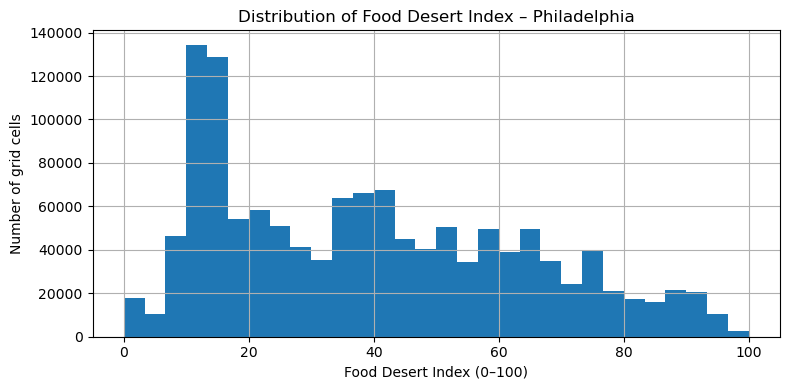

In [14]:
import matplotlib.pyplot as plt

# Basic summary of the index and categories
print("Food Desert Index summary:")
print(grid_clean["food_desert_index"].describe())

print("\nCategory counts:")
print(grid_clean["food_desert_category"].value_counts())

# Histogram of the index
fig, ax = plt.subplots(figsize=(8, 4))
grid_clean["food_desert_index"].hist(bins=30, ax=ax)
ax.set_xlabel("Food Desert Index (0–100)")
ax.set_ylabel("Number of grid cells")
ax.set_title("Distribution of Food Desert Index – Philadelphia")
plt.tight_layout()
plt.show()

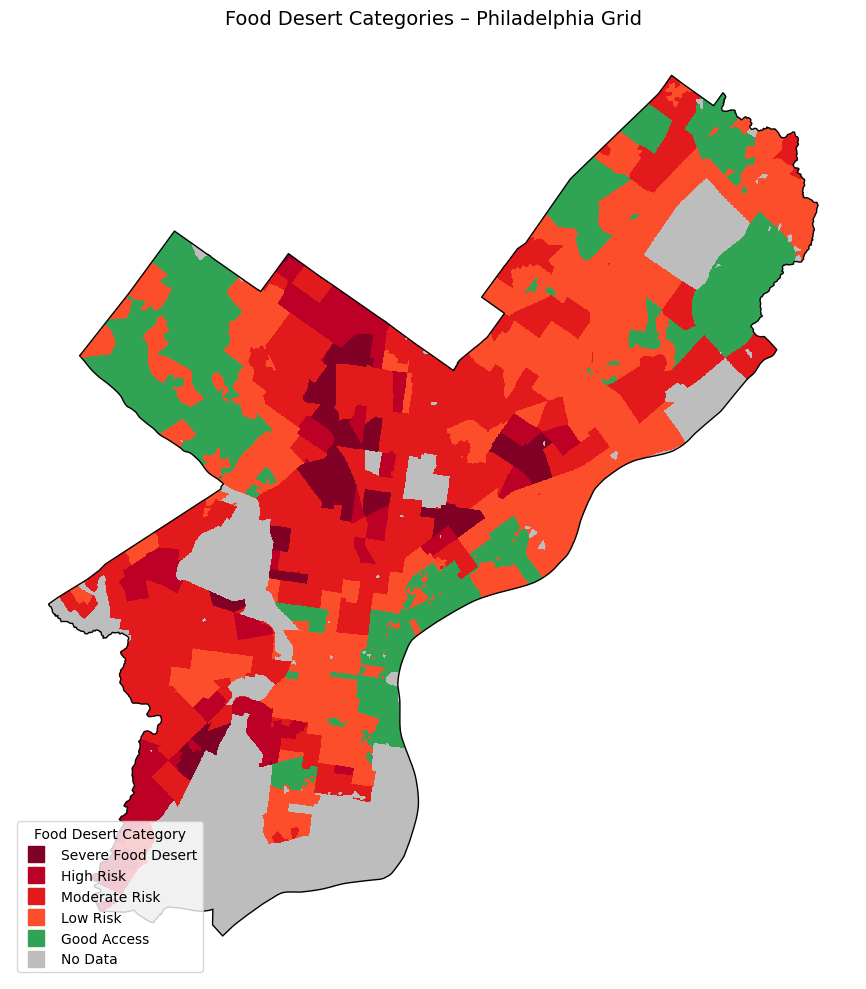

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a color for each category — in order
category_colors = {
    "Severe Food Desert": "#800026",   # dark red
    "High Risk": "#BD0026",            # red
    "Moderate Risk": "#E31A1C",        # orange-red
    "Low Risk": "#FC4E2A",             # orange
    "Good Access": "#31a354",          # green
    "No Data": "#bdbdbd"               # gray
}

# Create a column with colors for plotting
grid_clean["category_color"] = grid_clean["food_desert_category"].map(category_colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Outline of the city
philly_proj = philly.to_crs(grid_clean.crs)
philly_proj.boundary.plot(ax=ax, linewidth=1, color="black")

# Plot grid cells using custom color column
grid_clean.plot(
    color=grid_clean["category_color"],
    ax=ax,
    linewidth=0
)

# Create custom legend
handles = [
    plt.Line2D(
        [0], [0],
        marker='s', color=category_colors[c], label=c,
        markersize=12, linestyle='None'
    )
    for c in category_colors
]

ax.legend(
    handles=handles,
    title="Food Desert Category",
    loc="lower left",
    frameon=True
)

ax.set_title("Food Desert Categories – Philadelphia Grid", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.show()


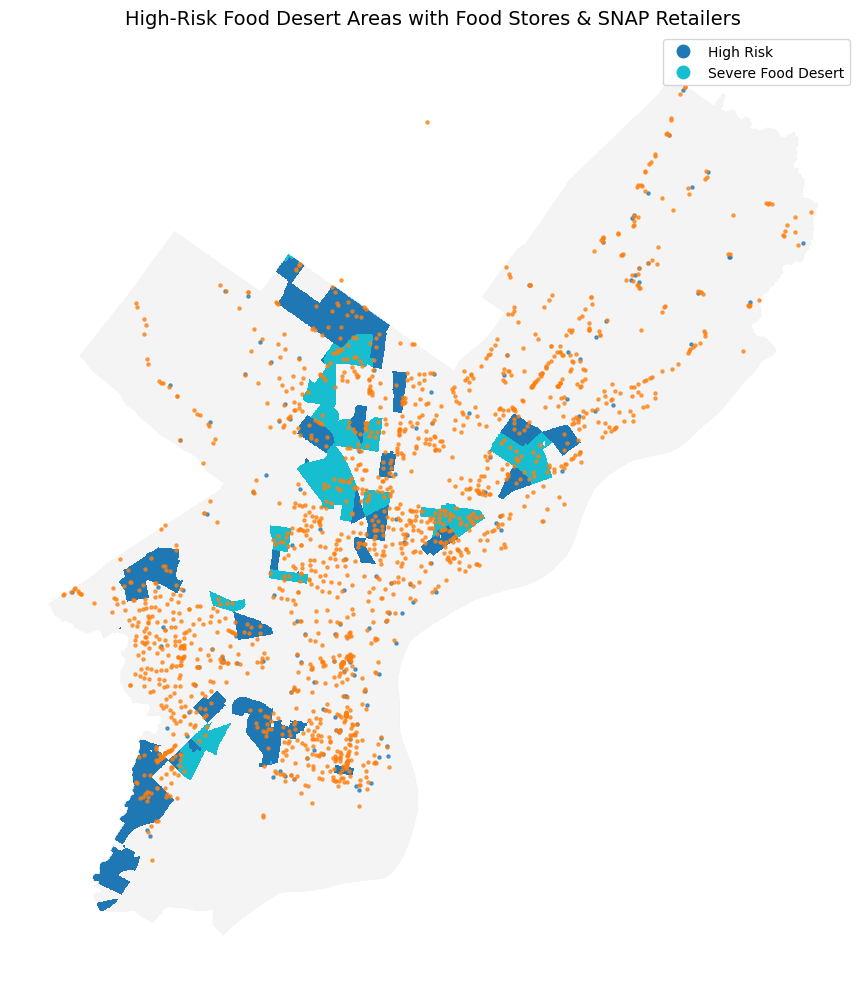

In [16]:
# Filter high-risk + severe cells
high_risk = grid_clean[grid_clean["food_desert_category"].isin(["High Risk", "Severe Food Desert"])]

# Make sure SNAP and food stores are in same CRS
snap_proj = snapgdf.to_crs(grid_clean.crs)
foodstore_proj = foodstore_proj.to_crs(grid_clean.crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Base: all grid cells (light)
grid_clean.plot(ax=ax, color="#eeeeee", linewidth=0, alpha=0.6)

# High-risk cells
high_risk.plot(
    ax=ax,
    column="food_desert_category",
    categorical=True,
    legend=True,
    linewidth=0
)

# Food stores and SNAP retailers
foodstore_proj.plot(ax=ax, markersize=5, alpha=0.7)
snap_proj.plot(ax=ax, markersize=5, alpha=0.7)

ax.set_title("High-Risk Food Desert Areas with Food Stores & SNAP Retailers", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [17]:
import geopandas as gpd

# 1. Start from the cleaned grid and ensure it has an active geometry
#    (the polygon grid cells)
grid_centroids = grid_clean.copy()
grid_centroids = grid_centroids.set_geometry("geometry")

# 2. Make sure grid and tracts are in the same CRS
#    merged_gdf already has tract geometries
grid_centroids = grid_centroids.to_crs(merged_gdf.crs)

# 3. Replace polygon geometry with centroids for the spatial join
#    (geometry column stays called "geometry", but now it's points)
grid_centroids["geometry"] = grid_centroids.geometry.centroid

# 4. Spatial join: which tract each grid cell centroid falls in
joined = gpd.sjoin(
    grid_centroids[["food_desert_index", "geometry"]],
    merged_gdf[["tract", "geometry"]],
    how="left",
    predicate="within"
)

# 5. Average food desert index per tract
tract_index = (
    joined
    .groupby("tract")["food_desert_index"]
    .mean()
    .reset_index()
)
tract_index.rename(
    columns={"food_desert_index": "food_desert_index_mean"},
    inplace=True
)

# 6. Merge back into tract polygons
tracts_with_index = merged_gdf.merge(
    tract_index,
    on="tract",
    how="left"
)

print("Finished aggregating. Columns now include 'food_desert_index_mean'.")


C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\812805674.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids["geometry"] = grid_centroids.geometry.centroid


Finished aggregating. Columns now include 'food_desert_index_mean'.


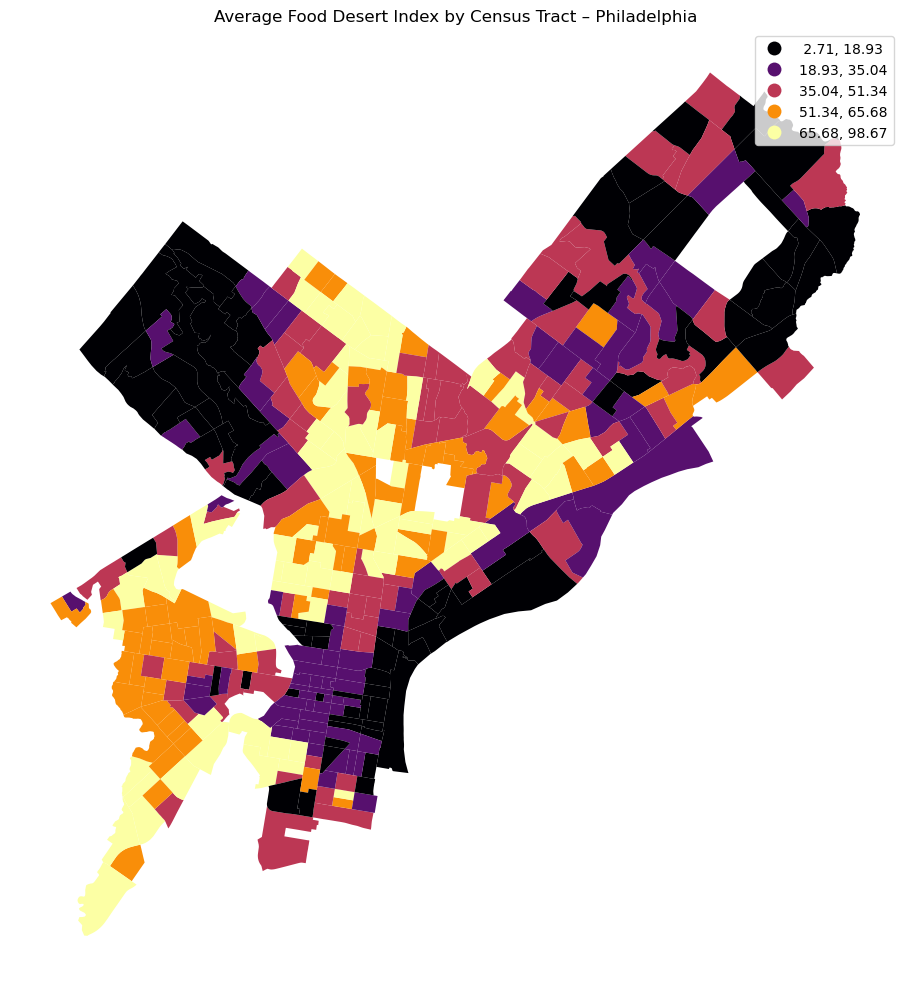

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts_with_index.plot(
    column="food_desert_index_mean",
    cmap="inferno",
    scheme="quantiles",
    k=5,
    legend=True,
    ax=ax
)

ax.set_title("Average Food Desert Index by Census Tract – Philadelphia")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [19]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.colormap import LinearColormap
from IPython.display import HTML

# Convert to WGS84 + keep geometry
gdf = tracts_with_index.set_geometry("geometry").to_crs(epsg=4326)

# Get map center
center_y = gdf.geometry.centroid.y.mean()
center_x = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_y, center_x], zoom_start=11)

# === Build Inferno colormap from matplotlib ===
vmin = gdf["food_desert_index_mean"].min()
vmax = gdf["food_desert_index_mean"].max()

# Use matplotlib inferno
inferno = cm.get_cmap("inferno", 256)

# Convert to HEX colors for folium
colors_list = [colors.rgb2hex(inferno(i)) for i in range(inferno.N)]

# Create folium colormap
colormap = LinearColormap(
    colors_list,
    vmin=vmin,
    vmax=vmax
)
colormap.caption = "Average Food Desert Index (0–100)"
colormap.add_to(m)

# === style + tooltip ===
def style_function(feature):
    val = feature["properties"].get("food_desert_index_mean")
    return {
        "fillColor": colormap(val) if val is not None else "#cccccc",
        "color": "black",
        "weight": 0.2,
        "fillOpacity": 0.7,
    }

tooltip = folium.GeoJsonTooltip(
    fields=[
        "tract",
        "food_desert_index_mean",
        "median_household_income",
        "poverty_rate",
        "unemployment_rate",
        "snap_rate",
    ],
    aliases=[
        "Tract:",
        "Food Desert Index (mean):",
        "Median HH Income:",
        "Poverty Rate (%):",
        "Unemployment Rate (%):",
        "SNAP Rate (%):",
    ],
    sticky=True,
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
).add_to(m)

HTML(m._repr_html_())


C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\3415471111.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_y = gdf.geometry.centroid.y.mean()
C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\3415471111.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_x = gdf.geometry.centroid.x.mean()
C:\Users\wensh\AppData\Local\Temp\ipykernel_30648\3415471111.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno = cm.get_cmap("inferno", 256)


In [20]:
import os

# Create outputs folder if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# 1. Aggregate the grid data to the Census Tract level
tract_summary = grid_clean.groupby('tract').agg({
    'food_desert_index': 'mean',
    'accessibility_score': 'mean',
    'economic_vulnerability': 'mean',
    'transportation_barrier': 'mean',
    'minority_score': 'mean',
    'poverty_rate': 'mean',
    'pct_black': 'mean',
    # For USDA definition, if >50% of grid cells in a tract are deserts, classify the tract as one
    'usda_food_desert': lambda x: 1 if (x.sum() / len(x)) > 0.5 else 0
}).reset_index()

# 2. Merge with the tract geometry
# We reuse 'tracts_gdf' from your earlier cell (Cell 6)
tracts_website = tracts_gdf[['tract', 'geometry']].merge(tract_summary, on='tract')

# 3. Save to GeoJSON
tracts_website.to_file("outputs/tract_summary.geojson", driver='GeoJSON')

print("Data saved to outputs/tract_summary.geojson")

Data saved to outputs/tract_summary.geojson
